
# Variational Autoencoder

In this notebook, you will implement a variational autoencoder and its variations. You will learn how to encode images into latent vectors follow gaussian distribution, and how to control images decoded from latent spaces with condtional variational autoencoder.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from visualize_util import visualize_img_batch, one_hot

In [4]:
# Use this if you are using any Cuda enabled system
if torch.cuda.is_available():
    device = 'cuda'
# elif torch.backends.mps.is_available():
#     device = 'mps' 
else:
    device = 'cpu'
print(device)

cpu


## Load MNIST Dataset

In [36]:
# TODO
input_dim = 28*28
hidden_dim = 400
latent_dim = 15
batch_size = 64
n_epochs = 10
# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

num_classes = 10
portioned_img_size = 14*14

# load the training and test datasets
mnist_train = datasets.MNIST('./data', train=True,
                                   download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False,
                                  download=True, transform=transform)


loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2)

loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, num_workers=2)  

In [37]:
a = torch.tensor([ [1,2,3,4], [5,6,7,8] ] )
a.sum(1)

tensor([10, 26])

In [43]:
# editing it to accomodate the conditional VAE

class myVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, conditional_vec_size=0):
        super(myVAE, self).__init__()
        self.input_dim =  input_dim # H*W
        self.latent_dim =  latent_dim # Z
        self.hidden_dim = hidden_dim # hidden
        self.conditional_vec_size = conditional_vec_size # only used in CVAE

        # input: (N,1,H,W) -> output: (N,hidden_dim)
        # if conditional_vec_size > 0: input: (N,hidden_dim + conditional_vec_size) -> output: (N,hidden_dim)
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim + self.conditional_vec_size, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        # input: (N,hidden_dim) -> output: (N, Z)
        self.mean_layer =   nn.Linear(self.hidden_dim, self.latent_dim)
        
        # input: (N,hidden_dim) -> output: (N, Z)
        self.logvar_layer = nn.Linear(self.hidden_dim, self.latent_dim)  
        
        # input: (N, Z) -> output: (N,1,H,W)
        self.decoder =   nn.Sequential(
            nn.Linear(latent_dim + self.conditional_vec_size, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    
    def forward(self, x, conditional_vec=None):
        
        # H*W -> HW + C
        if conditional_vec is not None:
            x = torch.cat((x.view(x.size(0), -1), conditional_vec), dim=-1)  
        else:
            x = x.view(x.size(0), -1)
        
        x_hat = self.encoder(x)
        mu = self.mean_layer(x_hat)
        logvar = self.logvar_layer(x_hat)
        z = self.reparametrize(mu, logvar)
        
        if conditional_vec is not None:
            z = torch.cat((z, conditional_vec), dim=-1)
        
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

    @staticmethod
    def reparametrize(mu, logvar):
        # TODO:
        var = torch.exp(logvar)
        sigma = torch.sqrt(var)
        z = mu + sigma * torch.randn_like(mu)
        return z
    
    @staticmethod
    def loss_function(x_hat, x, mu, logvar):
        # TODO: Compute negative variational lowerbound loss as described in the handout
        reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
        KL_loss = -1/2* (1 + logvar - mu**2 - torch.exp(logvar)).sum()
        loss = reconstruction_loss + KL_loss
        # from ta to normalize the loss
        loss = loss/ mu.shape[0]
        return loss

In [44]:
from torchsummary import summary
vae = myVAE(input_dim, hidden_dim, latent_dim).to(device)
summary(vae,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
         LeakyReLU-3                  [-1, 400]               0
            Linear-4                  [-1, 400]         160,400
            Linear-5                   [-1, 15]           6,015
            Linear-6                   [-1, 15]           6,015
            Linear-7                  [-1, 400]           6,400
         LeakyReLU-8                  [-1, 400]               0
            Linear-9                  [-1, 400]         160,400
        LeakyReLU-10                  [-1, 400]               0
           Linear-11                  [-1, 784]         314,384
          Sigmoid-12                  [-1, 784]               0
Total params: 967,614
Trainable params: 967,614
Non-trainable params: 0
-------------------------------

## Train

In [40]:
#TODO
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(n_epochs):
  vae.train()
  train_loss = 0
  loss = None
  for batch_idx, (data, labels) in enumerate(loader_train):
      #TODO
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass:
      pred, mu,logvar = vae(data)
      # print(pred.shape) # torch.Size([64, 784])
      # print(data.shape) # torch.Size([64, 1, 28, 28])

      data_flattned = data.view(data.size(0), -1)
      # calculate the loss using the loss function defined above
      loss = vae.loss_function(x_hat = pred, x = data_flattned, mu = mu, logvar = logvar)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update running training loss
      train_loss += loss.item()
  train_loss = train_loss/len(loader_train)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

Epoch: 1 	Training Loss: 155.811609
Epoch: 2 	Training Loss: 120.328797
Epoch: 3 	Training Loss: 114.185323
Epoch: 4 	Training Loss: 110.818584
Epoch: 5 	Training Loss: 108.668636
Epoch: 6 	Training Loss: 107.293359
Epoch: 7 	Training Loss: 106.196324
Epoch: 8 	Training Loss: 105.368603
Epoch: 9 	Training Loss: 104.710391
Epoch: 10 	Training Loss: 104.126724


## Results

torch.Size([100, 28, 28])



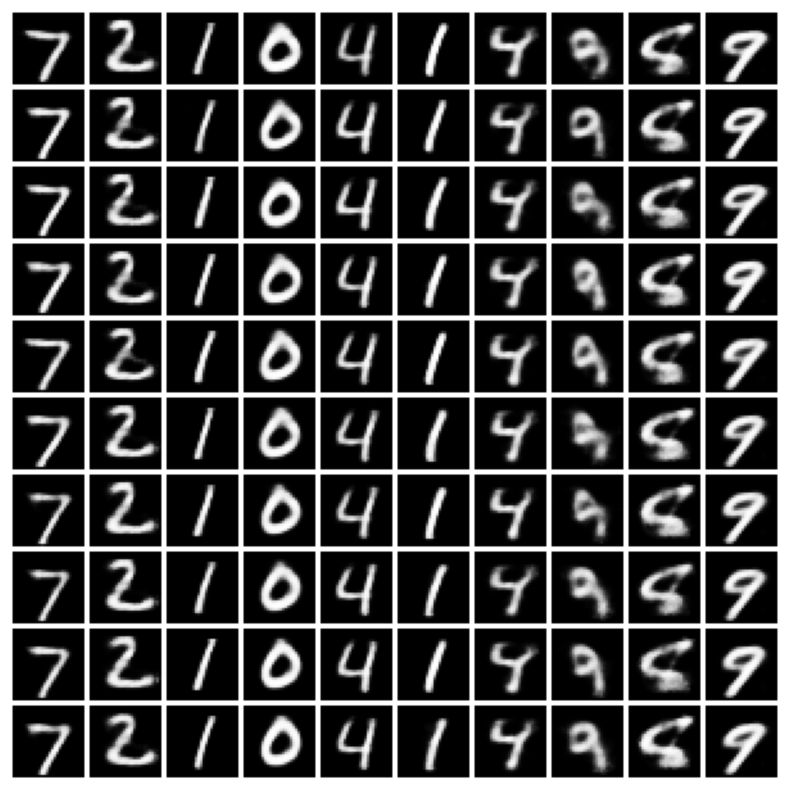

torch.Size([100, 28, 28])
sampled image with larger variance


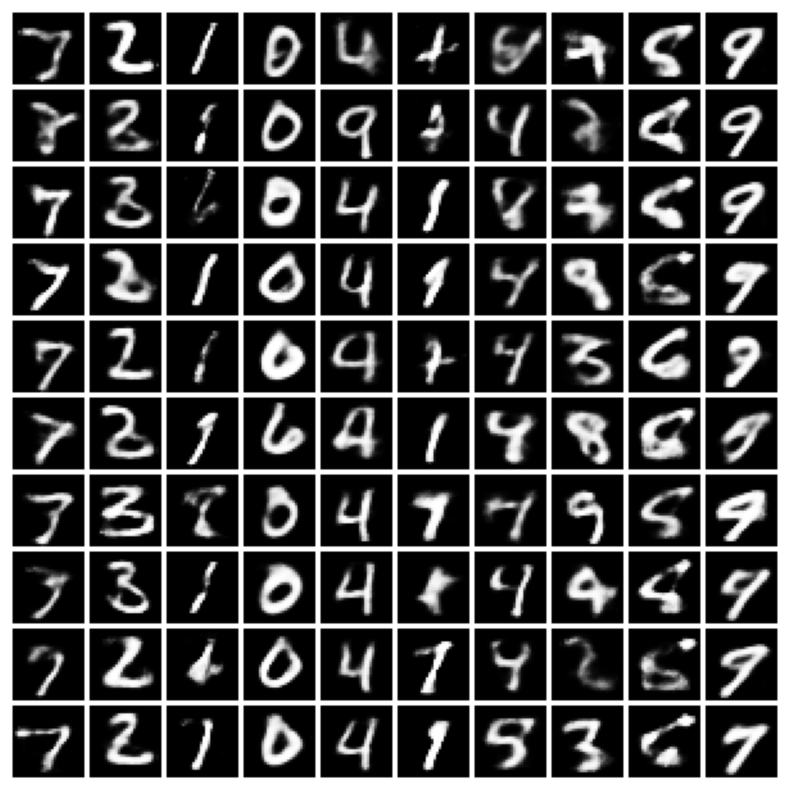

In [41]:
vae.eval()
images = next(iter(loader_test))[0][0:10,:,:,:] # assume batch size >10
images = images.repeat(10,1,1,1)

samples, mu, logvar = vae(images.to(device))
# show vae sampled images
samples = samples.reshape(samples.shape[0], 28, 28)
print(samples.shape)
print()
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

z = myVAE.reparametrize(mu, logvar+3)
samples = vae.decoder(z)
samples = samples.reshape(samples.shape[0], 28, 28)
print(samples.shape)

# # show vae sampled images with larger variance
print('sampled image with larger variance')
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

# CVAE

In [48]:
cvae = myVAE(input_dim, latent_dim=latent_dim,hidden_dim=hidden_dim, conditional_vec_size=num_classes).to(device)
# summary(cvae,(1,28,28))

In [49]:

optimizer = optim.Adam(cvae.parameters(), lr=1e-3)

for epoch in range(n_epochs):
  cvae.train()
  train_loss = 0
  loss = None
  for batch_idx, (data, labels) in enumerate(loader_train):
      #TODO
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass:
      one_hot_ = one_hot(labels, num_classes)
      pred, mu,logvar = cvae(data, one_hot_)
      # print(pred.shape) # torch.Size([64, 784])
      # print(data.shape) # torch.Size([64, 1, 28, 28])

      data_flattned = data.view(data.size(0), -1)
      # calculate the loss using the loss function defined above
      loss = cvae.loss_function(x_hat = pred, x = data_flattned, mu = mu, logvar = logvar)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update running training loss
      train_loss += loss.item()
  train_loss = train_loss/len(loader_train)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

Epoch: 1 	Training Loss: 149.458684
Epoch: 2 	Training Loss: 115.701058
Epoch: 3 	Training Loss: 109.649261
Epoch: 4 	Training Loss: 106.209356
Epoch: 5 	Training Loss: 104.029303
Epoch: 6 	Training Loss: 102.494198
Epoch: 7 	Training Loss: 101.305471
Epoch: 8 	Training Loss: 100.500699
Epoch: 9 	Training Loss: 99.776718
Epoch: 10 	Training Loss: 99.177681


## Results

sample shape torch.Size([10, 784])
sampled image


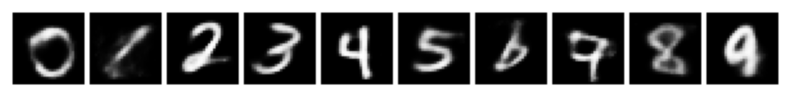

In [53]:
z = torch.randn(10, latent_dim)
c = torch.eye(10, 10) # [one hot labels for 0-9]
z = torch.cat((z,c), dim=-1).to(device)
cvae.eval()
samples = cvae.decoder(z)
print('sample shape', samples.shape)
samples = samples.reshape(samples.shape[0], 28, 28)
# show vae sampled images with larger variation
print('sampled image')
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

## CVAE + structured output prediction

sample shape torch.Size([10, 784])
sampled image


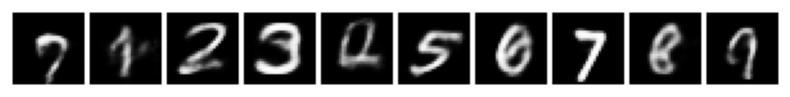

In [58]:
# x = torch.randn(10,28*28)
# x = x.reshape(x.shape[0], 28, 28)
# print(x.shape)
# print('sampled image')
# visualize_img_batch(x.detach().cpu().numpy().squeeze())
# plt.show()
z = torch.randn(10, latent_dim)
c = torch.eye(10, 10) # [one hot labels for 0-9]
z = torch.cat((z,c), dim=-1).to(device)
cvae.eval()
samples = cvae.decoder(z)
print('sample shape', samples.shape)
samples = samples.reshape(samples.shape[0], 28, 28)
# show vae sampled images with larger variation
print('sampled image')
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

sample shape torch.Size([10, 784])
sampled image
sample shape torch.Size([10, 28, 28])


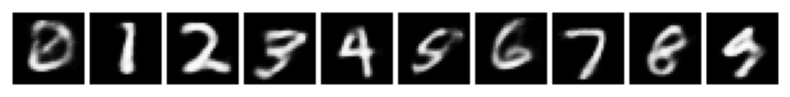

In [122]:
z = torch.randn(10, latent_dim)
c = torch.eye(10, 10) # [one hot labels for 0-9]
z = torch.cat((z,c), dim=-1).to(device)
cvae.eval()
samples = cvae.decoder(z)
print('sample shape', samples.shape)
samples = samples.reshape(samples.shape[0], 28, 28)
# show vae sampled images with larger variation
print('sampled image')
print('sample shape', samples.shape)
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

In [137]:
samples[:, 196*2:196*3].shape

torch.Size([10, 196])

torch.Size([10, 14, 14])
sampled image


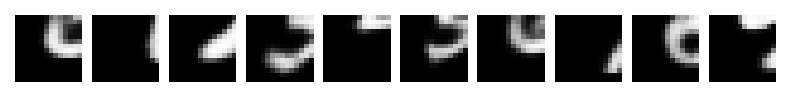

In [150]:
# samples = samples.reshape(samples.shape[0], 28*28)
# slices = samples[:, 196*2:196*3]
# print(slices.shape)
# slices = slices.reshape(slices.shape[0], 14,14)
samples = samples.view(-1, 28, 28)
slices = samples[:, -14:, :14]
print(slices.shape)
# # show vae sampled images with larger variation
print('sampled image')
visualize_img_batch(slices.detach().cpu().numpy().squeeze())
plt.show()

In [160]:
cvae = myVAE(input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim, conditional_vec_size = portioned_img_size)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)

for epoch in range(n_epochs):
  cvae.train()
  train_loss = 0
  loss = None
  for batch_idx, (data, labels) in enumerate(loader_train):
      # Slice the bottom left portion of the image
      # print(data.shape)
      slices = data[:, :, -14:, :14]
      # print(slices.shape)
      # Flatten it/ reshape it to (-1,14*14)
      slices = slices.reshape(slices.shape[0], 14*14)
      # print(slices.shape)
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # Forward pass with the conditional vector
      # print(data.shape, slices.shape)
      pred, mu, logvar = cvae(data, slices)
      # calculate the loss using the loss function defined above
      data_flattned = data.view(data.size(0), -1)
      # calculate the loss using the loss function defined above
      loss = cvae.loss_function(x_hat = pred, x = data_flattned, mu = mu, logvar = logvar)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update running training loss
      train_loss += loss.item()
  train_loss = train_loss/len(loader_train)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

Epoch: 1 	Training Loss: 133.534683
Epoch: 2 	Training Loss: 100.349576
Epoch: 3 	Training Loss: 94.978564
Epoch: 4 	Training Loss: 92.008737
Epoch: 5 	Training Loss: 90.045791
Epoch: 6 	Training Loss: 88.798720
Epoch: 7 	Training Loss: 87.796683
Epoch: 8 	Training Loss: 87.009204
Epoch: 9 	Training Loss: 86.416689
Epoch: 10 	Training Loss: 85.842222


## Baseline NN for structured output prediction

In [163]:
class BaselineNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        #TODO
        self.input_dim = input_dim
        self.decoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 28*28),
            nn.Sigmoid()
        )
        

    def forward(self, z):
        #TODO
        z = self.decoder(z)
        return z

In [164]:
baseline =  BaselineNN(input_dim = portioned_img_size).to(device)
criterion = nn.MSELoss() #TODO
optimizer = optim.Adam(baseline.parameters(), lr=1e-3)

for epoch in range(0, n_epochs):
  baseline.train()
  train_loss = 0
  loss = None
  for batch_idx, (data, labels) in enumerate(loader_train):
      # Slice the bottom left portion of the image
      # Flatten it/ reshape it to (-1,14*14)
      slices = data[:, :, -14:, :14]
      slices = slices.reshape(slices.shape[0], 14*14)
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # Forward pass with the conditional vector as input
      pred = baseline(slices)
      # calculate the loss using the criterion function defined above
      loss = criterion(pred, data.view(data.size(0), -1))
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update running training loss
      train_loss += loss.item()
      pass
  train_loss = train_loss/len(loader_train)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

Epoch: 1 	Training Loss: 0.041331
Epoch: 2 	Training Loss: 0.030952
Epoch: 3 	Training Loss: 0.029320
Epoch: 4 	Training Loss: 0.028409
Epoch: 5 	Training Loss: 0.027765
Epoch: 6 	Training Loss: 0.027274
Epoch: 7 	Training Loss: 0.026876
Epoch: 8 	Training Loss: 0.026537
Epoch: 9 	Training Loss: 0.026238
Epoch: 10 	Training Loss: 0.025974


## Results

Ground truth


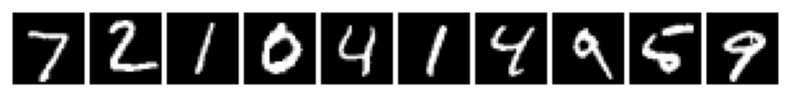

Quarter image


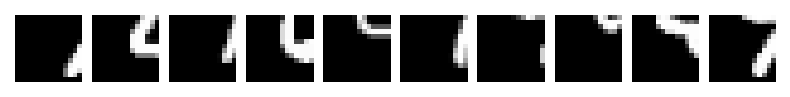

Baseline results


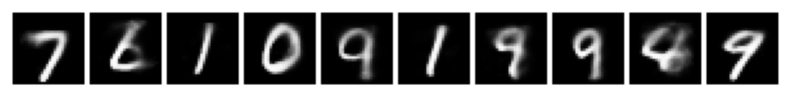

CVAE results


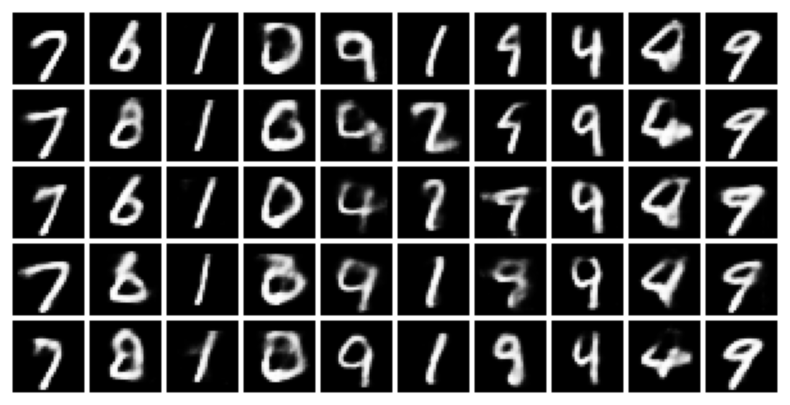

In [170]:
full_imgs = next(iter(loader_test))[0][0:10,:,:,:]
# TODO
# Slice the bottom left portion of the image
quad_imgs = full_imgs[:, :, -14:, :14]

print('Ground truth')
visualize_img_batch(full_imgs.detach().cpu().numpy().squeeze())
plt.show()

print('Quarter image')
visualize_img_batch(quad_imgs.detach().cpu().numpy().squeeze())
plt.show()

print('Baseline results')
baseline.eval()
samples = baseline(quad_imgs.to(device))
samples = samples.reshape(samples.shape[0], 28, 28)
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()

print('CVAE results')
cvae.eval()
num_random = 5
quad_imgs = quad_imgs.repeat(num_random ,1,1,1)
quad_imgs = torch.reshape(quad_imgs,(-1, 14*14))

z = torch.randn(num_random*10, latent_dim)
# print(z.shape, quad_imgs.shape) # [50,15] [50,196]
z = torch.cat((z,quad_imgs), dim = 1) #TODO: concat latent vector with the conditional_vec (quad_imgs)
samples = cvae.decoder(z).data
samples = samples.reshape(samples.shape[0], 28, 28)
visualize_img_batch(samples.detach().cpu().numpy().squeeze())
plt.show()